In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import tangent_boundaries as tb
from math import pi
from scipy.sparse import csr_matrix, csc_matrix, linalg as sla

sigma_0 = np.array([[1,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

def make_bands_x(parameters,number_of_bands = int(20), number_of_points = int(101),kmin = -pi, kmax = pi):
 
    momenta = np.linspace(kmin,kmax, num = number_of_points)
    bands = np.zeros((number_of_points,number_of_bands))
    #Solve generalised eigenproblem for all k
    plot_cell = True
    for j, k in enumerate(momenta):
        parameters['k'] = k
        Phi, H, P = operators_diag(parameters, plot_unit_cell= plot_cell)
        plot_cell= False
        bands[j] = sla.eigsh(H, M=P, k = number_of_bands, tol = 1e-7, sigma = 0.000001, which = 'LM',return_eigenvectors = False)

    return momenta,bands

In [2]:
def operators_diag(parameters, plot_unit_cell = False):
    
    theta = parameters['theta']
    number_of_sites = parameters['number_of_sites']
    k = parameters['k']
    
    x_coord = np.arange(number_of_sites)//2    #### This only works for 
    y_coord = (np.arange(1,number_of_sites+1))//2
    
    if plot_unit_cell:
        fig = plt.figure(figsize = (4,4))
        ax = fig.add_subplot(111)
        ax.scatter(x_coord[1:-1],y_coord[1:-1])
        ax.scatter(x_coord[[1,-2]],y_coord[[1,-2]])
        #ax.scatter(x_coord[[0,-1]],y_coord[[0,-1]])
        ax.set_aspect('equal')
        #fig.savefig('diagonal_shape.pdf')
    
    
    def get_index(x,y,number_of_sites):
        'Returns the index of the projection on a site onto the unit cell'
        return (2*((x+y)//2) + (x+y)%2)%number_of_sites
    
    def get_coordinates(index,number_of_sites):
        return np.array([[(index//2)%number_of_sites],[((index+1)//2)%number_of_sites]])
    
    def get_translation(x,y):
        'Returns the distance of the translation that brings a site onto the unit cell. The positive direction is southeast.'
        return np.sqrt(2)*((y-x)//2)  
    
    row_Tx = []
    col_Tx = []
    data_Tx = []
    
    row_Ty = []
    col_Ty = []
    data_Ty = []
    
    for (x,y) in zip(x_coord[:-1],y_coord[:-1]):
       
        row_Tx += [get_index(x,y,number_of_sites)]
        col_Tx += [get_index(x+1,y,number_of_sites)]
        if np.abs(get_index(x,y,number_of_sites)-get_index(x+1,y,number_of_sites))<5:
            data_Tx += [np.exp(1j*k*get_translation(x+1,y))] #Try making open boundaries
        else:
            data_Tx += [0]
        row_Ty += [get_index(x,y,number_of_sites)]
        col_Ty += [get_index(x,y+1,number_of_sites)]
        data_Ty += [np.exp(1j*k*get_translation(x,y+1))] #Try making open boundaries
    
    
    # Sparse matrices corresponding to translation operators
    Tx = csc_matrix((data_Tx, (row_Tx, col_Tx)), shape = (number_of_sites, number_of_sites))
    Ty = csc_matrix((data_Ty, (row_Ty, col_Ty)), shape = (number_of_sites, number_of_sites))
    one = scipy.sparse.identity(number_of_sites)
    
    phi_x = (Tx+one)/2
    phi_y = (Ty+one)/2
    sin_x = -(1j/2)*(Tx-Tx.H)
    sin_y = -(1j/2)*(Ty-Ty.H)
    
    hx = phi_y.H@sin_x@phi_y
    hy = phi_x.H@sin_y@phi_x
    phi = (phi_x@phi_y+phi_y@phi_x)/2
    
    H = scipy.sparse.kron(csc_matrix(sigma_x), hx, format = "csc") + scipy.sparse.kron(csc_matrix(sigma_y), hy, format = "csc")
    Phi = scipy.sparse.kron(csc_matrix(sigma_0), phi, format = "csc")
    
    
    # Unitary transformation on the edges. Let us build a rotation matrix that acts on a single site.
    def spin_rotation(site, theta, phi):
        'Unitary transformation that rotates the spin site to a theta,phi orientation'
        rotation = np.identity(2*number_of_sites, dtype = complex)
        
        spinup = get_index(site[0],site[1],number_of_sites)
        spindown = get_index(site[0],site[1],number_of_sites) + number_of_sites

        rotation[spinup,spinup] = np.cos(theta/2)
        rotation[spinup,spindown] = np.sin(theta/2)
        rotation[spindown,spinup] = -np.sin(theta/2)*np.exp(1j*phi)
        rotation[spindown,spindown] = np.cos(theta/2)*np.exp(1j*phi)
        
        return csc_matrix(rotation)
    
    edge_points = np.concatenate((get_coordinates(1,number_of_sites),get_coordinates(-2,number_of_sites)),axis=1)
    
    #normal_angles = np.array([4*pi/4,0*pi/4])
    normal_angles = np.array([5*pi/4,1*pi/4])
    boundary_spin_projections = normal_angles + np.ones(len(normal_angles))*pi/2
    
    for pp, point in enumerate(zip(edge_points[0], edge_points[1], boundary_spin_projections)):
        if pp ==0:
            rotation = spin_rotation([point[0],point[1]], pi-theta, point[2]) 
        else:
            rotation = spin_rotation([point[0],point[1]], theta, point[2]) 
        H = rotation.H@H@rotation
        Phi = rotation.H@Phi@rotation

    #fig = plt.figure(figsize = (7,7))
    #ax = fig.add_subplot(111)
    #ax.imshow(np.abs(Phi.toarray()))
        
    
    #Delete first and last points, together with spin down components of the second and second-to-last ones.
    indices_to_delete = [0,number_of_sites-1,
                          number_of_sites,number_of_sites+1,2*number_of_sites-2,2*number_of_sites-1]
    #indices_to_delete = [0,1,number_of_sites-1,
                        #number_of_sites,2*number_of_sites-2,2*number_of_sites-1]

    
    # Transforming the sparse matrix into dense to delete spins is probably not the best way to do this
    H_aux = H.toarray()
    Phi_aux = Phi.toarray()
    
    
    H_aux = np.delete(H_aux, indices_to_delete, axis=0)
    H_aux = np.delete(H_aux, indices_to_delete, axis=1)
    
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=0)
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=1)
        
    H = csc_matrix(H_aux)
    Phi = csc_matrix(Phi_aux)
    P = Phi.H@Phi

    
    #fig = plt.figure(figsize = (7,7))
    #ax = fig.add_subplot(111)
    #ax.imshow(np.abs(Phi.toarray()))

    
    return Phi, H, P

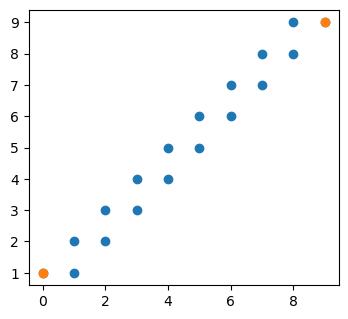

In [4]:
i = 100 ### selected value of theta
number_of_sites = 20

parameters = dict(
    number_of_sites = number_of_sites,
    theta = -(pi/2)*(i/100),
    k = 0,
)

Phi, H, P = operators_diag(parameters,plot_unit_cell=True)



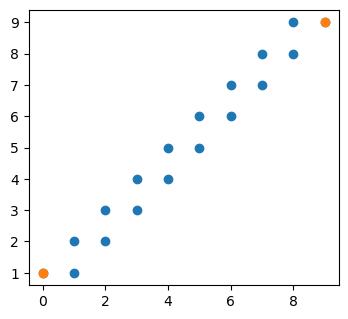

In [5]:
nbands = 18
momenta, bands = make_bands_x(parameters, number_of_bands = nbands, number_of_points = 401, kmin = -pi,kmax = pi)

Text(0.5, 0, '$k$ $(a^{-1})$')

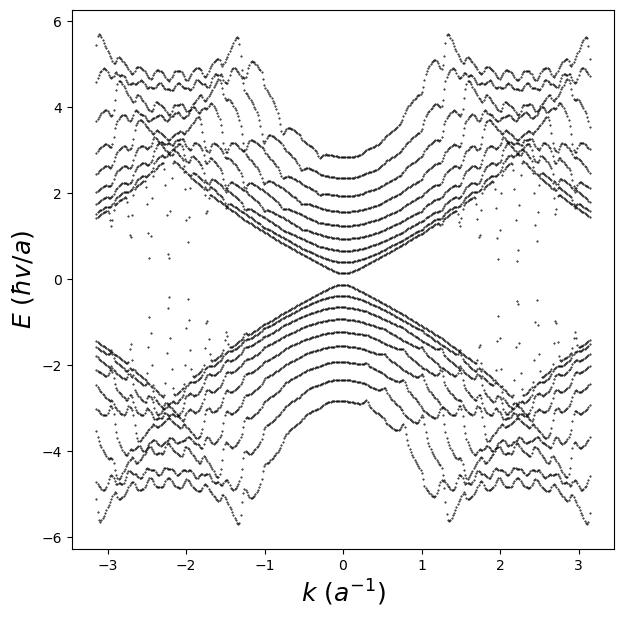

In [6]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
for i in range(nbands):
    ax.scatter(momenta, bands[:,i], c = 'k', s = 0.2)
#ax.axhline(0, c = 'k')
ax.set_ylabel(r"$E$ $(\hbar v/a)$",fontsize = 18)
ax.set_xlabel(r"$k$ $(a^{-1})$",fontsize = 18)
#ax.set_xlim(-1,1)
#ax.set_ylim(-1,1)

#fig.savefig('diagonal_intermediate.pdf')

In [ ]:
# Let me plot the modes actually

def plot_state(parameters,which_state=0):

    theta = parameters['theta']
    number_of_sites = parameters['number_of_sites']
    k = parameters['k']
    
    Phi, H, P = operators_diag(parameters, plot_unit_cell= plot_cell)
    energies, states = sla.eigsh(H, M=P, k = number_of_bands, tol = 1e-7, sigma = 0.000001, which = 'LM',return_eigenvectors = True)

    # Now reshape the states.

     def get_index(x,y,number_of_sites):
        'Returns the index of the projection on a site onto the unit cell'
        return (2*((x+y)//2) + (x+y)%2)%number_of_sites
    
    def get_coordinates(index,number_of_sites):
        return np.array([[(index//2)%number_of_sites],[((index+1)//2)%number_of_sites]])
    
    def get_translation(x,y):
        'Returns the distance of the translation that brings a site onto the unit cell. The positive direction is southeast.'
        return np.sqrt(2)*((y-x)//2) 

 X,Y = np.meshgrid(np.arange(-numbe),np.arange())    